## Programming Exercise 2: Logistic Regression

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1 Logistic Regression

In [2]:
datafile = 'C:\\Users\\Administrator\\Desktop\\Coursera-ML\\machine-learning-ex2\\ex2\\ex2data1.txt'
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True)  
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size  
X = np.insert(X,0,1,axis=1)

#### 1.1 Visualizing the data

In [3]:
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])
# 检查是否包含了所有的类
print("Included everything? ",(len(pos)+len(neg) == X.shape[0])) # 如果是false就查看数据集有没有问题

Included everything?  True


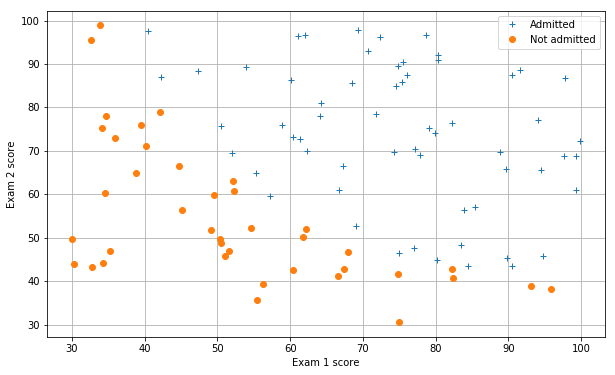

In [9]:
def plotData():
    plt.figure(figsize=(10,6))
    plt.plot(pos[:,1],pos[:,2],'+',label='Admitted')
    plt.plot(neg[:,1],neg[:,2],'o',label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.grid(True)
    
plotData()

#### 1.2 Implementation

In [10]:
from scipy.special import expit # 向量化sigmoid函数

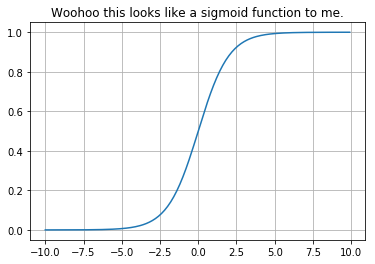

In [12]:
# 快速检查这个是不是跟我想到一样
myx = np.arange(-10,10,.1)
plt.plot(myx,expit(myx))
plt.title("Woohoo this looks like a sigmoid function to me.")
plt.grid(True)

In [23]:
# 逻辑回归中的损失函数和假设函数
def h(mytheta,myX):
    return expit(np.dot(myX,mytheta))

# 默认lambda为(正则化) 0
def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    Note this includes regularization, if you set mylambda to nonzero
    For the first part of the homework, the default 0. is used for mylambda
    """
    
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:])) #Skip theta0
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

In [24]:
# 检查theta为0时损失值是否返回为0.693:
initial_theta = np.zeros((X.shape[1],1))
computeCost(initial_theta,X,y)

0.6931471805599452

In [25]:
# 在OCTAVE中的fminunc在这里用scipy.optimize这个函数
# 注意“fmin”不需要明确告知衍生条款
# 它只需要成本函数，并通过“下坡单纯形算法”最小化。
# http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin(computeCost, x0=mytheta, args=(myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]


In [27]:
theta, mincost = optimizeTheta(initial_theta,X,y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [31]:
# 使用θ的最佳参数调用损失函数
# 现在的成本约为0.203

print(computeCost(theta,X,y))

0.2034977015902151


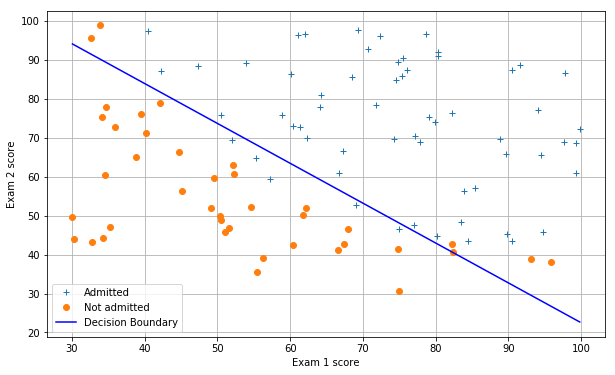

In [32]:
# 画出决策边界：两点，中间一条直线
# 决策边界发生在当h = 0, 或者当
#theta0 + theta1*x1 + theta2*x2 = 0
#y=mx+b 被x2 = (-1/thetheta2)(theta0 + theta1*x1)取代

boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plotData()
plt.plot(boundary_xs,boundary_ys,'b-',label='Decision Boundary')
plt.legend()
plt.show()

In [28]:
# 对于测试1分为45分且考试2分为85分的学生，

# 录取概率为0.776。
print(theta,np.array([1, 45.,85.]))

[-25.16130062   0.20623142   0.20147143] [ 1. 45. 85.]


In [30]:
def makePrediction(mytheta, myx):
    return h(mytheta,myx) >= 0.5

# 计算得到的样本百分比：
pos_correct = float(np.sum(makePrediction(theta,pos)))
neg_correct = float(np.sum(np.invert(makePrediction(theta,neg))))
tot = len(pos)+len(neg)
prcnt_correct = float(pos_correct+neg_correct)/tot
print("Fraction of training samples correctly predicted: %f." % prcnt_correct )

Fraction of training samples correctly predicted: 0.890000.


### 2 Regularized Logistic Regression

#### 2.1 Visualizing the data

In [34]:
datafile = 'C:\\Users\\Administrator\\Desktop\\Coursera-ML\\machine-learning-ex2\\ex2\\ex2data2.txt'
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) 
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X,0,1,axis=1)

In [35]:
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

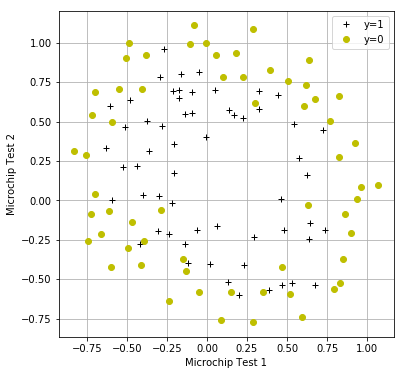

In [37]:
def plotData():
    plt.plot(pos[:,1],pos[:,2],'k+',label='y=1')
    plt.plot(neg[:,1],neg[:,2],'yo',label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

# 画出这个的平方突出圆形特征
plt.figure(figsize=(6,6))
plotData()

#### 2.2 Feature mapping

In [38]:
# 卷积网络的核心思想是将：局部感受野、权值共享（或者权值复制）以及时间或空间亚采样这三种结构思想结合起来获得了某种程度的位移、尺度、形变不变性.
def mapFeature( x1col, x2col ):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of featuers as described in the homework assignment
    """
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [40]:
mappedX = mapFeature(X[:,1],X[:,2])

#### 2.3 Cost function and gradient

In [42]:
# 损失函数与上面实现的函数相同，我包含了正则化

# 默认函数调用#toggled off（lambda = 0）

# I不需要单独实现损失函数的导数项

# 因为使用的scipy优化函数只需要成本函数本身

# 让我们检查损失函数返回的成本是0.693，初始theta为零，

# 然后正则化x的值
initial_theta = np.zeros((mappedX.shape[1],1))
computeCost(initial_theta,mappedX,y)

0.6931471805599453

##### 2.3.1 Learning parameters using fminunc

In [43]:
# fminunc找到函数最小值
# I注意到fmin没有收敛（传递最大迭代次数）
# 所以让我们使用最小化

def optimizeRegularizedTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun
    
theta, mincost = optimizeRegularizedTheta(initial_theta,mappedX,y)

#### 2.4 Plotting the decision boundary

In [45]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,mylambda)
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

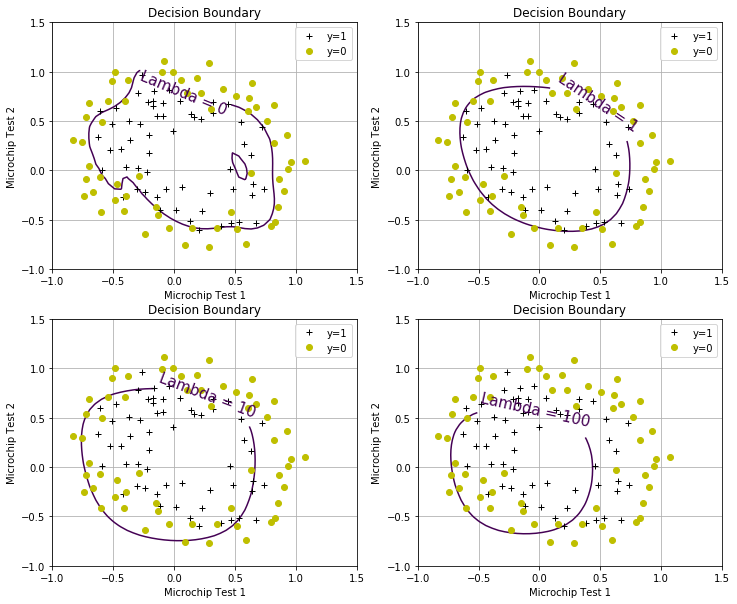

In [46]:
#Build a figure showing contours for various values of regularization parameter, lambda
#It shows for lambda=0 we are overfitting, and for lambda=100 we are underfitting
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1.)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)